# Ak Bars Online (mobile) churn rate prediction

### Источник данных

Для составления исходного dataFrame (df_main) используются сессионные данные, доступные в приложении ApMetrica, а также данные о платежах и переводах, отправляемых разработчиками в AppMetrica.

Количество пользователей считается по уникальному идентификатору устройства, который присваивается AppMetrica (параметр DeviceID).

### Импорт библиотек + вспомогательные функции для работы с данными Clickhouse

In [120]:
HOST = 'http://localhost:8123'
import requests
import pandas as pd
import numpy as np
import seaborn as sns
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# убираем scientific notation
pd.options.display.float_format = '{:.2f}'.format

# отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

import itertools
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

# возвращаем результат из DataBase
def get_clickhouse_data(query, host = HOST, connection_timeout = 1500):
    r = requests.post(host, params = {'query': query}, timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else:
        raise ValueError(r.text)
        
# преобразуем полученные данные в pandas DataFrame       
def get_clickhouse_df(query, host = HOST, connection_timeout = 1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(StringIO(data), sep = '\t')
    return df

# константы для работы с временными диапазонами

# вчерашняя дата
yesterday = [(datetime.date.today() - datetime.timedelta(days=2)).strftime('%Y-%m-%d'),
            (datetime.date.today() - datetime.timedelta(days=2)).strftime('%Y-%m-%d')]
# последние 7 дней (без учета текущей даты)
week_dates = [(datetime.date.today() - datetime.timedelta(days=7)).strftime('%Y-%m-%d'), \
(datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')]
# текущий месяц (без учета текущей даты)
month_dates = [datetime.date.today().strftime('%Y-%m-') + '01', \
(datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')]

# выставляем даты для отчета
query_dates = ['2018-06-01', '2018-07-31'];

# выставляем даты для целевого признака по оттоку
churn_query_dates = ['2018-08-01', '2018-08-31'];

# формат даты
fmt = '%Y-%m-%d'

# функция для расчета признаков, связанных с сессиями пользователей (например, avgdaylag (средний кол-во дней между сессиями))
def func(a):
    i1, i2 = itertools.tee(iter(a))
    next(i2)
    res = [(int(round((datetime.strptime(y, fmt) - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440
    for x, y in zip(i1, i2)]  # or just zip in Python 3
    return round(np.mean(res),2)

from datetime import datetime

# здесь выставляем первое число месяца, на который прогнозируем отток

reportDate = datetime(2018, 8, 1)

sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey'})
sns.set(palette='Blues')

## ВСЕ СЕССИИ

Получим данные по сессиям за период. В нашем случае за два месяца (июнь и июль 2018)

In [3]:
%%time

q = '''
SELECT
    DeviceID,
    AppVersionName,
    OSName,
    City,
    SessionStartDate,
    SessionStartDateTime,
    SessionStartTimestamp
FROM
    mobile.sessions_starts_all
WHERE
    SessionStartDate BETWEEN ''' + ''' \'''' + \
    query_dates[0] + '''\' AND ''' + '''\'''' + \
    query_dates[1] + '''\' ''''FORMAT TabSeparatedWithNames'''

sessions_2months = get_clickhouse_df(q)

CPU times: user 16.6 s, sys: 11.5 s, total: 28.1 s
Wall time: 47.6 s


Добавим данные за май и апрель 2018

In [4]:
sessions_may = pd.read_csv('../dmitriilin/Downloads/sessions_starts_may.csv', sep=',')
sessions_april = pd.read_csv('../dmitriilin/Downloads/sessions_starts_april.csv', sep=',')
sessions_may['SessionStartDate'] = sessions_may['SessionStartDateTime'].apply(lambda x: x.split(' ')[0])

In [5]:
frames = [sessions_2months, sessions_may, sessions_april]
sessions = pd.concat(frames)

Создадим общий dataframe для пользователей, куда будем добавлять агрегированные данные. Посчитаем кол-во сессий на DeviceID, используя SessionStartTimestamp в качестве ID сессии

In [7]:
%%time

df_main = sessions.groupby('DeviceID')[['SessionStartTimestamp']]\
    .count().reset_index().sort_values(by='SessionStartTimestamp', ascending=False)

CPU times: user 612 ms, sys: 223 ms, total: 835 ms
Wall time: 913 ms


Запишем дни сессий в порядке возрастания массивом в колонку SessionStartDate

In [8]:
df_main['SessionStartDate'] = [sorted(list(set(sessions['SessionStartDate'].loc[sessions['DeviceID'] == x['DeviceID']])))  
    for _, x in df_main.iterrows()]

Посчитаем среднюю продолжительность перерыва между днями, в течение которых были сессии

In [9]:
df_main['sessions_avgdaylag'] = df_main.apply(lambda x: func(x['SessionStartDate']), axis=1)

Если у пользователя был один активный день, то avgdaylag будет равен кол-ву дней с этого дня и до даты отчета

In [10]:
tempSer = df_main[df_main['sessions_avgdaylag'].isnull()]['SessionStartDate'].apply(
     lambda x: round((int(round((reportDate - datetime.strptime(x[0], fmt)).total_seconds() / 60))) / 1440))

In [11]:
df_main['sessions_avgdaylag'] = df_main['sessions_avgdaylag'].fillna(tempSer)

Посчитаем кол-во дней, прошешдишх с последней сессии пользователя от даты формирования отчета

In [12]:
temp = sessions.groupby('DeviceID')[['SessionStartDate']].max().reset_index()
temp['sessions_daysSinceLastSession'] = temp['SessionStartDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main = df_main.join(temp.drop(['SessionStartDate'], axis=1).set_index('DeviceID'), on='DeviceID')

Посчитаем количество дней, когда пользователь был активен в приложении

In [13]:
df_main['sessions_totaldaysactive'] = df_main['SessionStartDate'].apply(lambda x: len(x))

Удалим массив уникальных дат с сессиями и переименуем столбец SessionStartTimestamp

In [14]:
df_main = df_main.drop(['SessionStartDate'], axis=1).rename(index=str, columns={
    "SessionStartTimestamp": "sessions_totalnumber"
})

## ВСЕ СОБЫТИЯ

Создадим временный dataframe для всех событий

In [20]:
q = '''
SELECT
    AppVersionName,
    OSName,
    EventDate,
    ReceiveDate,
    ReceiveTimestamp,
    EventTimestamp,
    EventDateTime,
    EventName,
    DeviceID,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'crmId') AS VARCHAR) AS crmId,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'status') AS VARCHAR) AS authStatus,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'gender') AS VARCHAR) AS gender,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'тип операции') AS VARCHAR) AS operationType,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'сумма операции') AS VARCHAR) AS operationAmount,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'источник') AS VARCHAR) AS sender,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'валюта отправителя') AS VARCHAR) AS senderCurrency,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'получатель') AS VARCHAR) AS recipient,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'валюта получателя') AS VARCHAR) AS recipientCurrency,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'размер комиссии') AS VARCHAR) AS operationFee,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'способ операции') AS VARCHAR) AS operationMethod,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'срок') AS VARCHAR) AS depositTerm,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'валюта') AS VARCHAR) AS depositCurrency,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'ставка') AS VARCHAR) AS depositRate,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'название') AS VARCHAR) AS depositName,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'тип чата') AS VARCHAR) AS chatType,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'операция') AS VARCHAR) AS operation
FROM
    mobile.events_all
WHERE
    match(EventName,'продажи|переводы|Переводы|^платежи$')
    AND EventDate BETWEEN ''' + ''' \'''' + \
    query_dates[0] + '''\' AND ''' + '''\'''' + \
    query_dates[1] + '''\' ''''FORMAT TabSeparatedWithNames'''

events = get_clickhouse_df(q)

## ПЛАТЕЖИ

Создадим отдельный dataframe для платежей без добавления платежи, где сумма операция неизвестна (недоступна). Используем сумму операции, так как, если она пустая, то все остальные поля платежа тоже пустые.

In [32]:
payments_2months = events[(events['EventName'] == 'платежи')]

In [61]:
payments_2months = payments_2months.dropna(subset = ['operationAmount'])

Добавим данные за май и апрель 2018

In [62]:
payments_may = pd.read_csv('../dmitriilin/Downloads/payments_may.csv', sep=',')

In [63]:
payments_april = pd.read_csv('../dmitriilin/Downloads/payments_april.csv', sep=',')

In [64]:
frames = [payments_2months, payments_may, payments_april]
payments = pd.concat(frames)

In [65]:
payments.drop(['Unnamed: 0', 'chatType', 'depositCurrency', 'depositName', 'depositRate', 'depositTerm'],
              axis=1,
              inplace=True)

Рассчитаем агрегаты для платежей

In [66]:
f = {
    'operationAmount':['count','sum', 'median', 'min', 'max'], #количество, сумма, медиана, минимум и максимум
    'sender': ['nunique'], #кол-во уникальных источников платежей
    'recipient': ['nunique'], #кол-во получателей платежей
    'operationMethod': ['nunique'] #кол-во способов платежей
}

# расчитаем агрегаты по каждому DeviceID

payments_agg = payments.groupby(['DeviceID']).agg(f)
payments_agg.columns = payments_agg.columns.map('_'.join)
payments_agg = payments_agg.reset_index().rename(columns={
    'operationAmount_count': 'payments_operationAmount_count',
    'operationAmount_sum': 'payments_operationAmount_sum',
    'operationAmount_median': 'payments_operationAmount_median',
    'operationAmount_min': 'payments_operationAmount_min',
    'operationAmount_max': 'payments_operationAmount_max',
    'sender_nunique': 'payments_sender_nunique',
    'recipient_nunique': 'payments_recipient_nunique',
    'operationMethod_nunique': 'payments_operationMethod_nunique'
})

Запишем дни платежей в порядке возрастания массивом в колонку payments_date

In [67]:
payments_agg['payments_date'] = [sorted(list(set(payments['EventDate'].loc[payments['DeviceID'] == x['DeviceID']])))  
    for _, x in payments_agg.iterrows()]

Посчитаем среднюю продолжительность перерыва между днями, в течение которых были платежи.
Посчитаем количество дней, когда пользователь совершал платежи в приложении.

In [68]:
payments_agg['payments_avgdaylag'] = payments_agg.apply(lambda x: func(x['payments_date']), axis=1)
payments_agg['payments_daysactive'] = payments_agg['payments_date'].apply(lambda x: len(x))

payments_agg = payments_agg.drop(['payments_date'], axis=1)

Запишем данные о платежах в основой dataFrame

In [69]:
df_main = df_main.join(payments_agg.set_index('DeviceID'), on='DeviceID')

Посчитаем кол-во дней, прошешдишх с последнего платежаа пользователя от даты формирования отчета

In [70]:
temp = payments.groupby('DeviceID')[['EventDate']].max().reset_index()
temp['payments_daysSinceLastPayment'] = temp['EventDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main = df_main.join(temp.drop(['EventDate'], axis=1).set_index('DeviceID'), on='DeviceID')

Заполним отсутствующие данные для тех, кто ни разу не совершал платеж в выбранный период. Для признаков avgdaylag & daysSinceLastPayemnt запишем 122 дней (общее количество дней в периоде).

In [71]:
fillna0 = [
    'payments_operationAmount_count',
    'payments_operationAmount_sum',
    'payments_operationAmount_median',
    'payments_operationAmount_min',
    'payments_operationAmount_max',
    'payments_sender_nunique',
    'payments_recipient_nunique',
    'payments_operationMethod_nunique',
    'payments_daysactive'
]

fillna122 = ['payments_avgdaylag', 'payments_daysSinceLastPayment']

for i in fillna0:
    df_main[i].fillna(0, inplace=True)

for i in fillna122:
    df_main[i].fillna(122, inplace=True)

## ПЕРЕВОДЫ

Для переводов посчитаем те же агрегаты, что и для платежей

In [73]:
fundTransfers_2months = events[(events['EventName'] == 'переводы')]
fundTransfers_2months = fundTransfers_2months.dropna(subset = ['sender'])

In [74]:
fundTransfers_may = pd.read_csv('../dmitriilin/Downloads/transfers_may.csv', sep=',')

In [75]:
fundTransfers_april = pd.read_csv('../dmitriilin/Downloads/transfers_april.csv', sep=',')

In [76]:
frames = [fundTransfers_2months, fundTransfers_may, fundTransfers_april]
fundTransfers = pd.concat(frames)

In [77]:
f = {
    'operationAmount':['count','sum', 'median', 'min', 'max'], #количество и сумма операций
    'operationFee': ['sum'], #сумма комиссий
    'sender': ['nunique'], #кол-во источников перевода
    'recipient': ['nunique'], #кол-во получателей перевода
    'operationMethod': ['nunique'], #кол-во способов перевода
    'senderCurrency': ['nunique'], #кол-во валют источника перевода
    'recipientCurrency': ['nunique'] #кол-во валют получателя перевода
}

fundTransfers_agg = fundTransfers.groupby(['DeviceID']).agg(f)
fundTransfers_agg.columns = fundTransfers_agg.columns.map('_'.join)
fundTransfers_agg = fundTransfers_agg.reset_index().rename(columns={
    'operationAmount_count': 'transfers_operationAmount_count',
    'operationAmount_sum': 'transfers_operationAmount_sum',
    'operationAmount_median': 'transfers_operationAmount_median',
    'operationAmount_min': 'transfers_operationAmount_min',
    'operationAmount_max': 'transfers_operationAmount_max',
    'operationFee_sum': 'transfers_operationFee_sum',
    'sender_nunique': 'transfers_sender_nunique',
    'recipient_nunique': 'transfers_recipient_nunique',
    'operationMethod_nunique': 'transfers_operationMethod_nunique',
    'senderCurrency_nunique': 'transfers_senderCurrency_nunique',
    'recipientCurrency_nunique': 'transfers_recipientCurrency_nunique'
})

In [78]:
fundTransfers_agg['transfers_date'] = [sorted(list(set(fundTransfers['EventDate'].loc[fundTransfers['DeviceID'] == x['DeviceID']])))  
    for _, x in fundTransfers_agg.iterrows()]

fundTransfers_agg['transfers_avgdaylag'] = fundTransfers_agg.apply(lambda x: func(x['transfers_date']), axis=1)
fundTransfers_agg['transfers_daysactive'] = fundTransfers_agg['transfers_date'].apply(lambda x: len(x))

fundTransfers_agg = fundTransfers_agg.drop(['transfers_date'], axis=1)

In [79]:
df_main = df_main.join(fundTransfers_agg.set_index('DeviceID'), on='DeviceID')

In [80]:
temp = fundTransfers.groupby('DeviceID')[['EventDate']].max().reset_index()
temp['transfers_daysSinceLastTransfer'] = temp['EventDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main = df_main.join(temp.drop(['EventDate'], axis=1).set_index('DeviceID'), on='DeviceID')

In [81]:
fillna0 = [
    'transfers_operationAmount_count',
    'transfers_operationAmount_sum',
    'transfers_operationAmount_median',
    'transfers_operationAmount_min',
    'transfers_operationAmount_max',
    'transfers_operationFee_sum',
    'transfers_sender_nunique',
    'transfers_recipient_nunique',
    'transfers_operationMethod_nunique',
    'transfers_senderCurrency_nunique',
    'transfers_recipientCurrency_nunique',
]

fillna122 = ['transfers_avgdaylag', 'transfers_daysactive', 'transfers_daysSinceLastTransfer']

for i in fillna0:
    df_main[i].fillna(0, inplace=True)

for i in fillna122:
    df_main[i].fillna(122, inplace=True)

## СЧИТАЕМ CHURN И ПРОСТАВЛЯЕМ TARGET FEATURE

In [82]:
q = '''
SELECT
    DeviceID,
    AppVersionName,
    OSName,
    ReceiveDate,
    ReceiveTimestamp,
    SessionStartDate,
    SessionStartDateTime,
    SessionStartTimestamp
FROM
    mobile.sessions_starts_all
WHERE
    SessionStartDate BETWEEN ''' + ''' \'''' + \
    churn_query_dates[0] + '''\' AND ''' + '''\'''' + \
    churn_query_dates[1] + '''\' ''''FORMAT TabSeparatedWithNames'''

sessions = get_clickhouse_df(q)


# посчитаем кол-во сессий на DeviceID, используя SessionStartTimestamp в качестве ID сессии

df_sessions_churn = sessions.groupby('DeviceID')[['SessionStartTimestamp']]\
    .count().reset_index().sort_values(by='SessionStartTimestamp', ascending=False)

Посмотрим, какие DeviceID, из тех, что присутствуют в общем dataFrame за период, вернулись в прогнозируем периоде. Если DeviceID найден, ставим "0" (неотток), в противном случае - "1" (отток)

In [83]:
df_main['churned'] = df_main['DeviceID'].isin(df_sessions_churn['DeviceID']).apply(lambda x: 0 if x is True else 1)

Как видим, 4-месячный отток составляет порядка 30% процентов.

In [84]:
df_main['churned'].value_counts(normalize=True)

0   0.67
1   0.33
Name: churned, dtype: float64

Посмотрим, как признаки из разных категория коррелируют с целевым

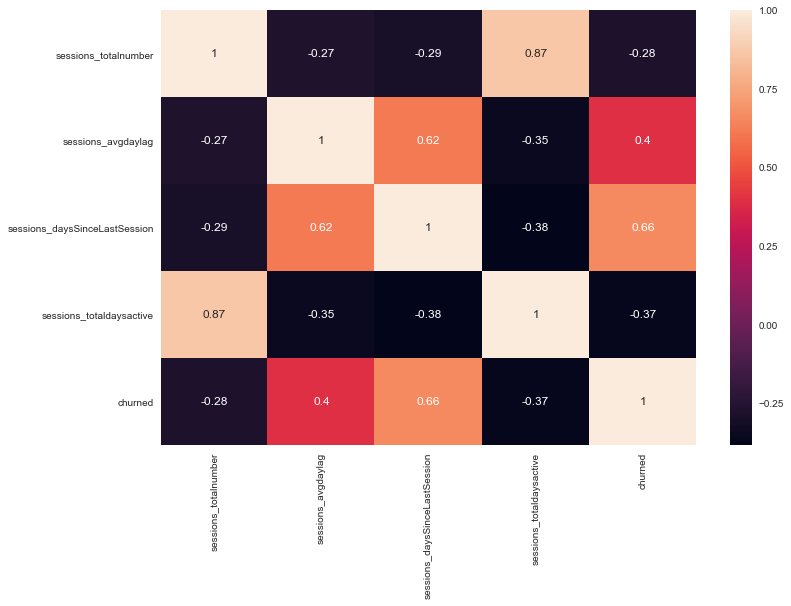

In [85]:
sns.heatmap(df_main[[f for f in df_main.columns if 'sessions' in f or 'churned' in f]].corr(), annot=True);
# sns.heatmap(df_main[[f for f in df_main.columns if 'payments' in f or 'churned' in f]].corr(), annot=True);
# sns.heatmap(df_main[[f for f in df_main.columns if 'transfers' in f or 'churned' in f]].corr(), annot=True);

Наконец, посмотрим на получившийся dataFrame

In [86]:
df_main.head()

,DeviceID,sessions_totalnumber,sessions_avgdaylag,sessions_daysSinceLastSession,sessions_totaldaysactive,payments_operationAmount_count,payments_operationAmount_sum,payments_operationAmount_median,payments_operationAmount_min,payments_operationAmount_max,...,transfers_operationFee_sum,transfers_sender_nunique,transfers_recipient_nunique,transfers_operationMethod_nunique,transfers_senderCurrency_nunique,transfers_recipientCurrency_nunique,transfers_avgdaylag,transfers_daysactive,transfers_daysSinceLastTransfer,churned
185272,17711056090712135034,2429,1.00,1,122,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,0
113760,10870103398657921835,2376,1.02,1,120,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,0
89049,8503699400535621652,2121,2.02,1,61,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,0
17655,1684057822033854533,2031,1.46,1,84,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,0
99239,9476564823644259242,1767,1.00,1,122,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,0


In [212]:
df_main.columns

Index(['DeviceID', 'sessions_totalnumber', 'sessions_avgdaylag',
       'sessions_daysSinceLastSession', 'sessions_totaldaysactive',
       'payments_operationAmount_count', 'payments_operationAmount_sum',
       'payments_operationAmount_median', 'payments_operationAmount_min',
       'payments_operationAmount_max', 'payments_sender_nunique',
       'payments_recipient_nunique', 'payments_operationMethod_nunique',
       'payments_avgdaylag', 'payments_daysactive',
       'payments_daysSinceLastPayment', 'transfers_operationAmount_count',
       'transfers_operationAmount_sum', 'transfers_operationAmount_median',
       'transfers_operationAmount_min', 'transfers_operationAmount_max',
       'transfers_operationFee_sum', 'transfers_sender_nunique',
       'transfers_recipient_nunique', 'transfers_operationMethod_nunique',
       'transfers_senderCurrency_nunique',
       'transfers_recipientCurrency_nunique', 'transfers_avgdaylag',
       'transfers_daysactive', 'transfers_daysSinceLa

In [211]:
df_main.shape

(193054, 43)

In [213]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193054 entries, 185272 to 45952
Data columns (total 43 columns):
DeviceID                                          193054 non-null uint64
sessions_totalnumber                              193054 non-null int64
sessions_avgdaylag                                193054 non-null float64
sessions_daysSinceLastSession                     193054 non-null int64
sessions_totaldaysactive                          193054 non-null int64
payments_operationAmount_count                    193054 non-null float64
payments_operationAmount_sum                      193054 non-null float64
payments_operationAmount_median                   193054 non-null float64
payments_operationAmount_min                      193054 non-null float64
payments_operationAmount_max                      193054 non-null float64
payments_sender_nunique                           193054 non-null float64
payments_recipient_nunique                        193054 non-null float64
payments_

__________________

## FEATURE ENGINEERING

### Добавим признаки

Добавим несколько новых признаков, основывающихся, прежде всего, на сессионых данных пользователей.

In [98]:
# общее количество сессий за 3 месяца меньше 2

df_main['sessions_totalnumber_less_2'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x < 2 else 0)

In [101]:
# общее количество сессий за 3 месяца меньше 6

df_main['sessions_totalnumber_less_6'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x < 6 else 0)

In [103]:
# общее количество активных дней за 1 месяц меньше 2

df_main['sessions_totaldaysactive_less_2'] = df_main['sessions_totaldaysactive'].apply(lambda x: 1 if x < 2 else 0)

In [104]:
df_main['sessions_avgdaylag_greater_20'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 20.5 else 0)
df_main['sessions_avgdaylag_greater_10'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 10 else 0)
df_main['sessions_avgdaylag_greater_15'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 15 else 0)
df_main['sessions_totaldaysactive_equalsless_2'] = df_main['sessions_totaldaysactive'].apply(lambda x: 1 if x <= 2 else 0)
df_main['sessions_daysSinceLastSession_equalsgreater_19'] = df_main['sessions_daysSinceLastSession'].apply(lambda x: 1 if x >= 19 else 0)
df_main['sessions_totalnumber_equalsless_5'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x <= 5 else 0)

In [106]:
def label_race(row):
    if (row['sessions_avgdaylag_greater_10'] == 1 and row['sessions_totaldaysactive_equalsless_2'] == 1 and
        row['sessions_daysSinceLastSession_equalsgreater_19'] == 1 and row['sessions_totalnumber_equalsless_5'] == 1):
        return 1
    else:
        return 0

In [107]:
df_main['sessions_isPassive'] = df_main.apply(lambda row: label_race (row),axis=1)

In [111]:
df_main['payments_isPassive'] = df_main['payments_operationAmount_count'].apply(lambda x: 1 if x == 0 else 0)
df_main['transfers_isPassive'] = df_main['transfers_operationAmount_count'].apply(lambda x: 1 if x == 0 else 0)

Построим кор. матрицу для "сессионных" признаков

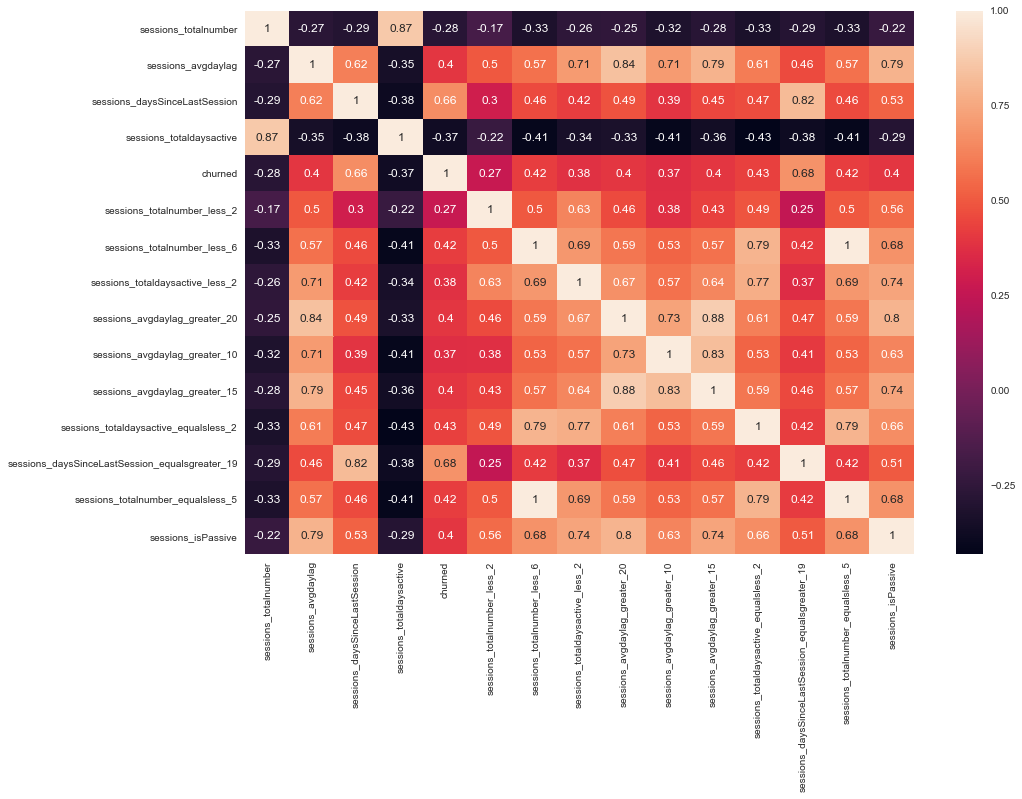

In [114]:
fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(df_main.corr());
sns.heatmap(df_main[[f for f in df_main.columns if 'sessions' in f or 'churned' in f]].corr(), annot=True);

_______

## ОБУЧАЕМ МОДЕЛЬ (-И)

In [115]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from collections import Counter

In [195]:
y = df_main['churned']
X = df_main.drop('churned', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.33, random_state=42)

# df_small = X_valid

Как помним, целевой признак за 4 месяца слегка не сбалансирован (67 и 33). Попробуем выравнить его, используя библиотеку imbalance-learn. Для этого создадим отдельные сеты с сентетическими данными X_train_res / y_train_res

In [345]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

In [346]:
sm = SMOTE(random_state=42, kind='borderline2', k_neighbors=3)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(y_train.value_counts(), np.bincount(y_train_res))
print(sorted(Counter(y_train_res).items()))

0    85816
1    35937
Name: churned, dtype: int64 [85816 85816]
[(0, 85816), (1, 85816)]


Сразу подберем оптимальное значение для параметра k_neighbors

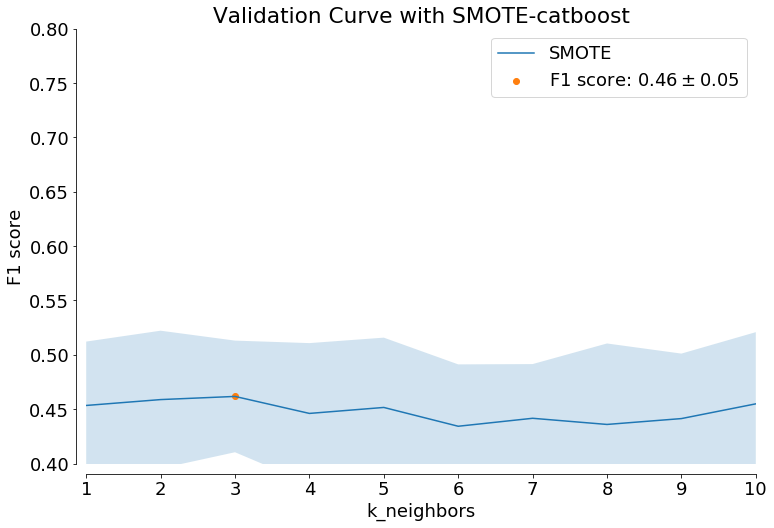

CPU times: user 7.05 s, sys: 1.17 s, total: 8.22 s
Wall time: 25min 32s


In [309]:
%%time
from sklearn import model_selection
from sklearn import metrics

from imblearn import over_sampling as os
from imblearn import pipeline as pl

RANDOM_STATE = 42

scorer = metrics.make_scorer(metrics.f1_score)


smote = os.SMOTE(random_state=RANDOM_STATE)
catboost = model
pipeline = pl.make_pipeline(smote, catboost)

param_range = list(range(1, 11))

train_scores, test_scores = model_selection.validation_curve(
    pipeline, X, y, param_name="smote__k_neighbors", param_range=param_range,
    cv=3, scoring=scorer, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(param_range, test_scores_mean, label='SMOTE')
ax.fill_between(param_range, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
idx_max = np.argmax(test_scores_mean)
plt.scatter(param_range[idx_max], test_scores_mean[idx_max],
            label=r'F1 score: ${0:.2f}\pm{1:.2f}$'.format(
                test_scores_mean[idx_max], test_scores_std[idx_max]))

plt.title("Validation Curve with SMOTE-catboost")
plt.xlabel("k_neighbors")
plt.ylabel("F1 score")

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([1, 10])
plt.ylim([0.4, 0.8])

plt.legend(loc="best")
plt.show()

__________________

## RANDOM FOREST

In [147]:
from sklearn.ensemble import RandomForestClassifier

In [148]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, max_depth=6, max_features=10)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=10)))

0.8655079818761076


In [149]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [150]:
print(classification_report(y_valid, forest.predict(X_valid), target_names=['non-churned', 'churned']))

             precision    recall  f1-score   support

non-churned       0.90      0.90      0.90     42202
    churned       0.80      0.80      0.80     21506

avg / total       0.86      0.86      0.86     63708



In [203]:
forest_params = {
    'max_depth': list(range(5,40,10)),
    'max_features': list(range(5,41,10)) + [40]
}

forest_grid = GridSearchCV(forest, forest_params, cv=10, n_jobs=-1, verbose=True, scoring='f1') #try randomsearchgrid

In [204]:
forest_grid.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 47.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 15, 25, 35], 'max_features': [5, 15, 25, 35, 40]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=True)

In [205]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 5, 'max_features': 25}, 0.7977511867871151)

In [206]:
print(classification_report(y_valid, forest_grid.predict(X_valid), target_names=['non-churned', 'churned']))

             precision    recall  f1-score   support

non-churned       0.89      0.92      0.90     42202
    churned       0.83      0.77      0.80     21506

avg / total       0.87      0.87      0.87     63708



## XGBOOST

In [194]:
from IPython.display import display

import re
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV

In [196]:
X = np.array(df_main.drop('churned', 1))
training_features = np.array(df_main.drop('churned', 1).columns)
#X = preprocessing.scale(X)  --- not needed for XGboost?
y = np.array(df_main['churned'])

In [197]:
xgb = xgb.XGBClassifier()
cv = cross_validation.KFold(len(X), n_folds=20, shuffle=True, random_state=42)
scores = cross_validation.cross_val_score(xgb, X, y, cv=5, n_jobs=-1, verbose=True, scoring='f1')
xgb.fit(X_train, y_train)
print(scores)
print('F1: %.3f stdev: %.2f' % (np.mean(np.abs(scores)), np.std(scores)))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


[0.01795856 0.01249308 0.03026422 0.15006361 0.50510503]
F1: 0.143 stdev: 0.19


In [198]:
report = classification_report(y_valid, xgb.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.92      0.90     42202
    Churned       0.82      0.77      0.80     21506

avg / total       0.87      0.87      0.87     63708



In [199]:
xgbgridparams = {'learning_rate':[0, 0.001, 0.002, 0.004, 0.006, 0.008, 0.010, 0.1], 
       'reg_lambda':[0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]}

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgbgridparams,
    scoring='f1',
    n_jobs=-1,
    refit=True,
    verbose=True,
    cv=5)
xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 31.4min finished


{'learning_rate': 0.1, 'reg_lambda': 1.0}
0.7995659727017969


In [200]:
report = classification_report(y_valid, xgb_grid.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.92      0.90     42202
    Churned       0.82      0.77      0.80     21506

avg / total       0.87      0.87      0.87     63708



## GradientBoosting (LIGHT)

In [187]:
import lightgbm as lgb

# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {
    'boosting_type': 'gbdt',
    'max_depth' : -1,
    'objective': 'binary',
    'nthread': 3, # Updated from nthread
    'num_leaves': 34,
    'learning_rate': 0.1,
    'max_bin': 1024,
    'subsample_for_bin': 200,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 5,
    'reg_lambda': 10,
    'min_split_gain': 0.5,
    'min_child_weight': 1,
    'min_child_samples': 5,
    'scale_pos_weight': 1,
    'num_class' : 1,
    'metric' : 'binary_logloss',
    'num_iterations' : 200
}

gridParams = {
    'learning_rate': [0.1],
    'n_estimators': [40],
    'num_leaves': [31],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1.2, 1.4],
    'reg_lambda' : [1.2, 1.4]
}

lgbm = lgb.LGBMClassifier(
    boosting_type= params['boosting_type'],
    objective = params['objective'],
    n_jobs = -1, # Updated from 'nthread'
    silent = True,
    max_depth = params['max_depth'],
    max_bin = params['max_bin'],
    subsample_for_bin = params['subsample_for_bin'],
    subsample = params['subsample'],
    subsample_freq = params['subsample_freq'],
    min_split_gain = params['min_split_gain'],
    min_child_weight = params['min_child_weight'],
    min_child_samples = params['min_child_samples'],
    scale_pos_weight = params['scale_pos_weight'],
    learning_rate = params['learning_rate'],
    num_iterations=params['num_iterations'],
    num_leaves=params['num_leaves']
)

In [188]:
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_bin=1024, max_depth=-1, min_child_samples=5,
        min_child_weight=1, min_split_gain=0.5, n_estimators=100,
        n_jobs=-1, num_iterations=200, num_leaves=34, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1)

In [189]:
# F1 score для litegb - параметры НЕоптимизированы

report = classification_report(y_valid, lgbm.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.91      0.90     42202
    Churned       0.82      0.78      0.80     21506

avg / total       0.87      0.87      0.87     63708



In [190]:
%%time
lgbm_grid = GridSearchCV(lgbm, gridParams,
                    verbose=True,
                    cv=5,
                    n_jobs=-1, scoring='f1')
lgbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.0min finished


CPU times: user 18.5 s, sys: 1.84 s, total: 20.3 s
Wall time: 6min 1s


In [191]:
lgbm_grid.best_params_, lgbm_grid.best_score_

({'boosting_type': 'gbdt',
  'colsample_bytree': 0.65,
  'learning_rate': 0.1,
  'n_estimators': 40,
  'num_leaves': 31,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 1.2,
  'reg_lambda': 1.2,
  'subsample': 0.75},
 0.8005829365766747)

In [192]:
# F1 score для litegb - параметры НЕоптимизированы

report = classification_report(y_valid, lgbm.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.91      0.90     42202
    Churned       0.82      0.78      0.80     21506

avg / total       0.87      0.87      0.87     63708



In [193]:
# F1 score для litegb - параметры оптимизированы

report = classification_report(y_valid, lgbm_grid.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.91      0.90     42202
    Churned       0.82      0.78      0.80     21506

avg / total       0.87      0.87      0.87     63708



## CATBOOST

In [219]:
from catboost import CatBoostClassifier, cv, Pool

In [220]:
model = CatBoostClassifier(
    custom_loss=['F1'],
    random_seed=42,
    logging_level='Silent'
)

In [221]:
# np.where(X.dtypes != np.float)[0]

In [222]:
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    plot=False
);

Learning rate set to 0.130013


In [223]:
cv_data = cv(
    Pool(X, y),
    model.get_params(),
    plot=False
)

Learning rate set to 0.066243


In [224]:
print('Best validation F1 score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-F1-mean']),
    cv_data['test-F1-std'][np.argmax(cv_data['test-F1-mean'])],
    np.argmax(cv_data['test-F1-mean'])
))

Best validation F1 score: 0.80±0.00 on step 190


In [225]:
print('Precise validation F1 score: {}'.format(np.max(cv_data['test-F1-mean'])))

Precise validation F1 score: 0.8021206213855446


In [226]:
model_without_seed = CatBoostClassifier(iterations=500, logging_level='Silent')
model_without_seed.fit(X_train, y_train)

print('Random seed assigned for this model: {}'.format(model_without_seed.random_seed_))

Learning rate set to 0.123018
Random seed assigned for this model: 155474316006478


In [227]:
params = {
    'iterations': 200,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent'
}
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_valid, y_valid)

In [228]:
cb = CatBoostClassifier(**params)
cb.fit(train_pool, eval_set=validate_pool)

# best_model_params = params.copy()
# best_model_params.update({
#     'use_best_model': True
# })
# best_model = CatBoostClassifier(**best_model_params)
# best_model.fit(train_pool, eval_set=validate_pool);

print('Best model validation F1: {:.4}'.format(
#     accuracy_score(y_valid, best_model.predict(X_valid))
    f1_score(y_valid, cb.predict(X_valid))
))

Best model validation F1: 0.8028


### Пробуем Early Stopping

In [229]:
%%time
params.update({
    'od_type': 'Iter',
    'od_wait': 50
})
cb_early_stopping = CatBoostClassifier(**params)
cb_early_stopping.fit(train_pool, eval_set=validate_pool);

CPU times: user 30.1 s, sys: 1.02 s, total: 31.1 s
Wall time: 9.57 s


In [230]:
print('Early-stopped best model tree count: {}'.format(cb.tree_count_))
print('Early-stopped best model validation F1: {:.4}'.format(
    f1_score(y_valid, cb_early_stopping.predict(X_valid))
))

Early-stopped best model tree count: 73
Early-stopped best model validation F1: 0.8028


In [231]:
cb_early_stopping.get_params(), cb.get_params()

({'eval_metric': 'F1',
  'iterations': 200,
  'learning_rate': 0.1,
  'logging_level': 'Silent',
  'loss_function': 'Logloss',
  'od_type': 'Iter',
  'od_wait': 50,
  'random_seed': 42},
 {'eval_metric': 'F1',
  'iterations': 200,
  'learning_rate': 0.1,
  'logging_level': 'Silent',
  'loss_function': 'Logloss',
  'random_seed': 42})

### Пробуем оптимизировать параметры

In [232]:
import  hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=100, #make 50
        eval_metric='F1',
        random_seed=42,
        logging_level='Silent'
    )
    
    cv_data = cv(
        Pool(X, y),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [233]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1)
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

{'l2_leaf_reg': 3.0, 'learning_rate': 0.3320996532481362}


In [234]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=100,
    eval_metric='F1',
    random_seed=42,
    logging_level='Silent',
    use_best_model=True
)
cv_data = cv(Pool(X, y), model.get_params())

In [235]:
print('Precise validation F1 score: {}'.format(np.max(cv_data['test-F1-mean'])))


Precise validation F1 score: 0.8021127156643941


In [236]:
# F1 score для CatBoost - параметры НЕоптимизированы

report = classification_report(y_valid, cb.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.91      0.90     42202
    Churned       0.82      0.79      0.80     21506

avg / total       0.87      0.87      0.87     63708



In [237]:
model.fit(train_pool, eval_set=validate_pool);

In [238]:
# F1 score для CatBoost - параметры оптимизированы

report = classification_report(y_valid, model.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.89      0.91      0.90     42202
    Churned       0.82      0.79      0.80     21506

avg / total       0.87      0.87      0.87     63708



### CONFUSION MATRIX ДЛЯ LGBM

Confusion matrix, without normalization
[[38560  3642]
 [ 4688 16818]]


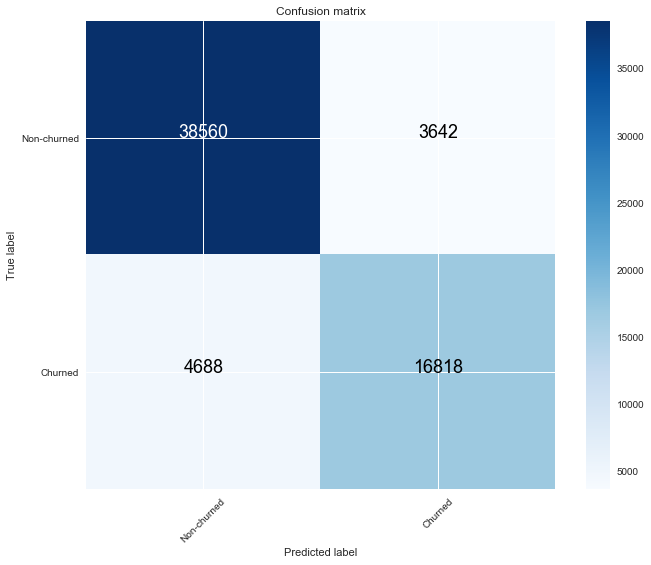

In [239]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 18}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_valid, lgbm.predict(X_valid))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()